# Poisson equation in a multipatch domain

In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, vform, geometry, vis, solvers

Populating the interactive namespace from numpy and matplotlib


In [2]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 15),)

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-pi/2).translate((-2, 1))
]

patches = [(kvs, g) for g in geos]

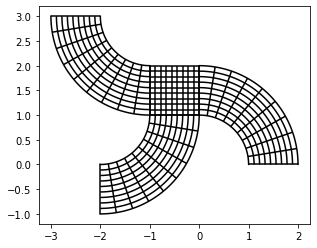

In [4]:
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [5]:
# source term f and Dirichlet boundary function g
f = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g = lambda x,y: 1e-1 * sin(8*x)

# set up Dirichlet boundary conditions
dir_data = [
    (0, 'bottom', g), (0, 'right', g),
    (1, 'top', g),
    (2, 'left', g), (2, 'bottom', g),
    (3, 'bottom', 0),
]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().

MP = assemble.Multipatch(patches, b_data = {'D':dir_data}, automatch=True)

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
A, rhs, _, _, _ = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

# generate Dirichlet data for global boundary dofs
dir_bcs = MP.compute_dirichlet_bcs()

In [6]:
# set up and solve linear system
LS = assemble.RestrictedLinearSystem(A, rhs, dir_bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch (kvs on every patch)
u_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u)
           for p in range(len(patches))]

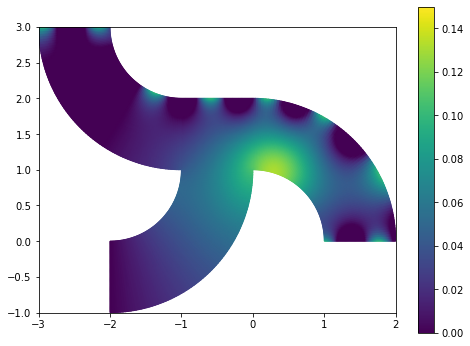

In [7]:
figsize(8,6)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axis('scaled')
colorbar();